In [1]:
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import hdf5storage
import time
import h5py
from torch.utils.data import Dataset, DataLoader

from core import losses
from core import model_utils
from core import data_loader
from core import models_seg

In [2]:
data_path = "/media/damingshen/05ba0687-eb77-48c2-a767-e9a44fbe94c1/Daming_data"
model_path = data_path + "/models"

train_path = data_path + "/Ashitha/Transplant/Training"
x_folder = "Input_image_Mag_SPEED"  # 4C Mag PAMRA  Mag_SPEED
y_folder = "Ref_mask"
x_fnames = os.listdir(train_path + "/" + x_folder)
x_files = [os.path.join(train_path, x_folder, fname) for fname in x_fnames]
y_fnames = os.listdir(train_path + "/" + y_folder)
y_files = [os.path.join(train_path, y_folder, fname[:-9] + "mask.mat") for fname in x_fnames]
print(len(x_files))

325


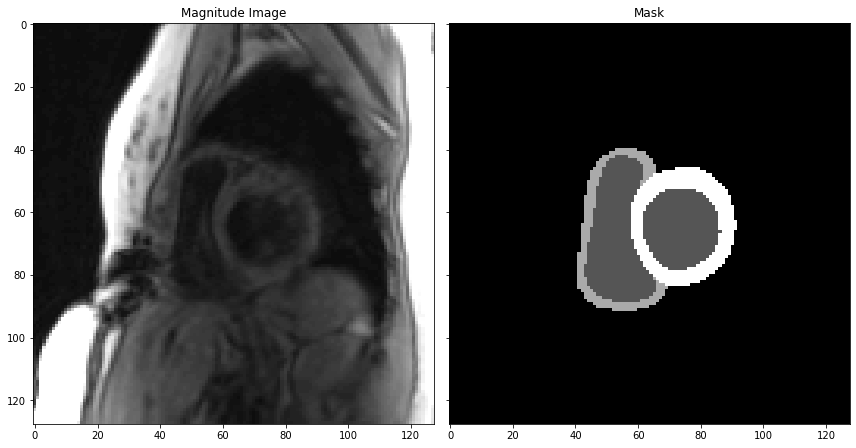

torch.Size([1, 2, 30, 128, 128]) torch.Size([1, 30, 128, 128])


In [4]:
import random
idx = random.randint(0,len(x_fnames)-1)
dataset = data_loader.Loader3D_TPM(x_files[idx:idx+1], y_files[idx:idx+1], imsize = 128,mode =None)
loader = DataLoader(dataset,
                 batch_size = 1,
                 shuffle = True,
                 drop_last = False,
                 num_workers = 1)
for batch_idx, data in enumerate(loader):
    x = data["x"]
    y = data["y"]
cy = y.data.numpy()
cx = x.data.numpy()
# print(cx.shape,cy.shape)
mag  = cx[0,0,5]*5
mask = cy[0,5]
vmin = 0
vmax= 3
fig, ax = plt.subplots(1,2, sharex=True, sharey=True, figsize=(12,8))
ax[0].imshow(mag, cmap = "gray", vmin = vmin, vmax = vmax)
ax[1].imshow(mask, cmap = "gray", vmin = vmin, vmax = vmax)

ax[0].set_title("Magnitude Image")
ax[1].set_title("Mask")

fig.tight_layout()
plt.show()
print(x.shape,y.shape)

In [5]:
gpu_no = "0"
device = torch.device("cuda:"+str(gpu_no) if torch.cuda.is_available() else "cpu")
batch_size = 1
epochs = 100
lr = 1e-4
print_step = 50
num_workers = 6
lamda = 10e3
################################### network ###############################
# Unet_seg3D_2Dpool_Depth5 Unet_seg3D_2Dpool
mrinet = models_seg.Dense_Unet_4L(features=64,drop_out = 0.05,in_channel = 2, classes = 4, mode = None).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, mrinet.parameters()), lr = lr, betas = (0.9, 0.99))

In [6]:
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')
exit_flag = False

model_name = "TPM_Seg_DenseUnet_Mag_SPEED.pth"

for i in range(epochs):
    total_loss = 0
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, mrinet.parameters()), lr = lr, betas = (0.9, 0.99))
    dataset = data_loader.Loader3D_TPM(x_files, y_files, imsize = 128,mode =None)
    loader = DataLoader(dataset,
                         batch_size = batch_size,
                         shuffle = True,
                         drop_last = True,
                         num_workers = num_workers)
    
    if exit_flag:
        break

    try:
        for batch_idx, data in enumerate(loader):
            optimizer.zero_grad()
            loss = 0
            x = data["x"].to(device)
            y = data["y"].to(device)
            out = mrinet(x)  
            loss =  loss_fn(out, y)+ losses.dice_loss_TPM(out, y) + losses.AveragedHausdorffLoss(out, y, 0.5)
            loss.backward()
            optimizer.step()
            total_loss = total_loss + loss.data.cpu().numpy()
            if (batch_idx+1)%print_step == 0:
                logging.info("Epoch {:},Batch = {:}, Learning Rate = {:.8f}, Loss= {:.8f}".format(i+1,(batch_idx+1)*batch_size,lr,total_loss/((batch_idx+1)*batch_size)))
    except KeyboardInterrupt:
        exit_flag = True
#     lr = lr*0.95
print("Exiting training")
mrinet.save(path = model_path, filename = model_name, optimizer=optimizer)

2021-03-17 10:45:16,646 Epoch 1,Batch = 50, Learning Rate = 0.00010000, Loss= 6.78154664
2021-03-17 10:47:05,927 Epoch 1,Batch = 100, Learning Rate = 0.00010000, Loss= 5.51507715
2021-03-17 10:48:56,600 Epoch 1,Batch = 150, Learning Rate = 0.00010000, Loss= 4.93512701
2021-03-17 10:50:48,712 Epoch 1,Batch = 200, Learning Rate = 0.00010000, Loss= 4.49887408
2021-03-17 10:52:39,749 Epoch 1,Batch = 250, Learning Rate = 0.00010000, Loss= 4.23660004
2021-03-17 10:54:28,289 Epoch 1,Batch = 300, Learning Rate = 0.00010000, Loss= 4.02753071
2021-03-17 10:57:09,087 Epoch 2,Batch = 50, Learning Rate = 0.00010000, Loss= 2.95923470
2021-03-17 10:58:59,960 Epoch 2,Batch = 100, Learning Rate = 0.00010000, Loss= 2.92604190
2021-03-17 11:00:48,271 Epoch 2,Batch = 150, Learning Rate = 0.00010000, Loss= 2.84289409
2021-03-17 11:02:40,315 Epoch 2,Batch = 200, Learning Rate = 0.00010000, Loss= 2.85106385
2021-03-17 11:04:31,233 Epoch 2,Batch = 250, Learning Rate = 0.00010000, Loss= 2.82859546
2021-03-17 1

Exiting training
model saved as: /media/damingshen/05ba0687-eb77-48c2-a767-e9a44fbe94c1/Daming_data/models/TPM_Seg_DenseUnet_Mag_SPEED.pth


In [7]:
train_path = data_path + "/Ashitha/Transplant/Testing"
x_folder = "Input_image_Mag_SPEED"  # 4C Mag PAMRA
y_folder = "Ref_mask"
x_fnames = os.listdir(train_path + "/" + x_folder)
x_files = [os.path.join(train_path, x_folder, fname) for fname in x_fnames]
y_fnames = os.listdir(train_path + "/" + y_folder)
y_files = [os.path.join(train_path, y_folder, fname[:-9] + "mask.mat") for fname in x_fnames]

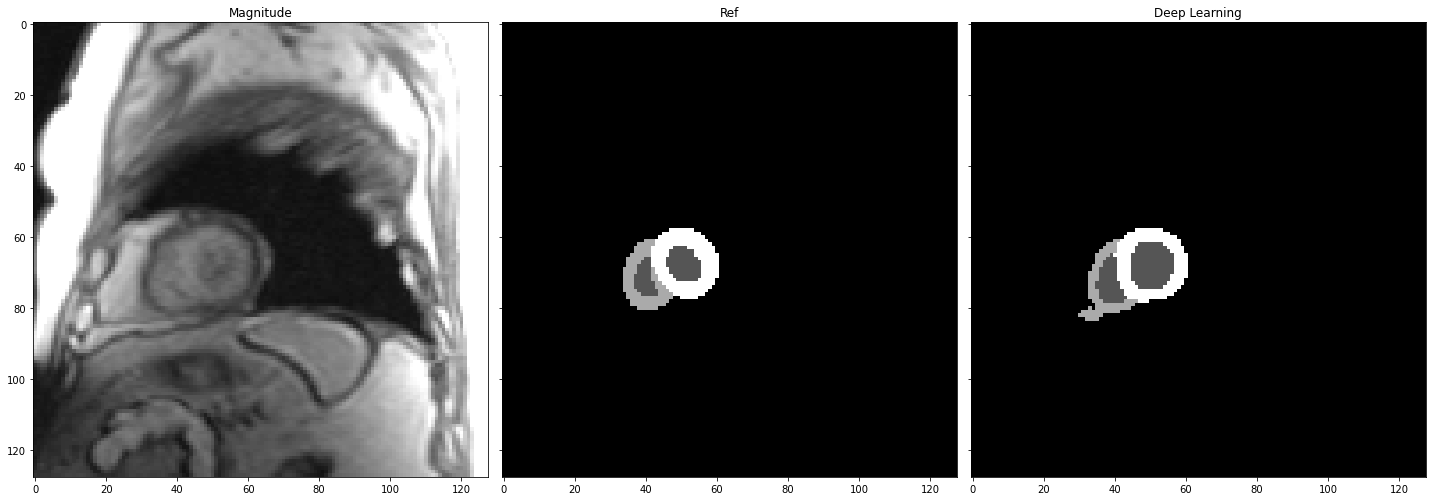

['/media/damingshen/05ba0687-eb77-48c2-a767-e9a44fbe94c1/Daming_data/Ashitha/Transplant/Testing/Input_image_Mag_SPEED/87510_014_GW_6mo_Roberto_slice1_image.mat']


In [9]:
import random
idx = random.randint(0,len(x_fnames)-1)
dataset = data_loader.Loader3D_TPM(x_files[idx:idx+1], y_files[idx:idx+1], imsize = 128,mode =None)
loader = DataLoader(dataset,
                 batch_size = 1,
                 shuffle = True,
                 drop_last = False,
                 num_workers = 1)

for batch_idx, data in enumerate(loader):
            x = data["x"].to(device)
            y = data["y"].to(device)
# mrinet.to(device)         
mrinet.eval()   
out = mrinet(x)
out = torch.argmax(out,dim=1,keepdim =True)

cy = y.data.cpu().numpy()
cx = x.data.cpu().numpy()
cout = out.data.cpu().numpy()
# del out,x,y
torch.cuda.empty_cache()
t_frame = 5
mag = cx[0,0,t_frame]*5
mask = cy[0,t_frame] 
DL = cout[0,0,t_frame]

vmin = 0
vmax= 3
fig, ax = plt.subplots(1,3, sharex=True, sharey=True, figsize=(20,15))
ax[0].imshow(np.abs(mag), cmap = "gray", vmin = vmin, vmax = vmax)
ax[1].imshow(np.abs(mask), cmap = "gray", vmin = vmin, vmax = vmax)
ax[2].imshow(np.abs(DL), cmap = "gray", vmin = vmin, vmax = vmax)

ax[0].set_title("Magnitude")
ax[1].set_title("Ref")
ax[2].set_title("Deep Learning")

fig.tight_layout()
plt.show()
print(x_files[idx:idx+1])

In [10]:
import logging
import scipy.io

logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')
DL_folder = "Recon_DL/Dense_UNet_Mag_SPEED"
x_suffix="image.mat"
DL_suffix="Dense_UNet_Mag_SPEED.mat"
mrinet.eval()
for idx in range(len(x_files)):
    dataset = data_loader.Loader3D_TPM(x_files[idx:idx+1], y_files[idx:idx+1], imsize = 128,mode =None)
    loader = DataLoader(dataset,
                 batch_size = 1,
                 shuffle = False,
                 drop_last = False,
                 num_workers = 1)
    for batch_idx, data in enumerate(loader):
        x = data["x"].to(device)
#         y = data["y"].to(device)
    out = mrinet(x)
    out = torch.argmax(out,dim=1,keepdim =True)
    cout = out.data.cpu().numpy()
    cout = cout[0,0] 
    
    Dense_UNet_Mag_SPEED = np.squeeze(cout)
    
    x_file = x_files[idx]
    DL_file = x_file.replace(x_folder,DL_folder)
    DL_file = DL_file.replace(x_suffix,DL_suffix)
#     hdf5storage.savemat(DL_file, dict(UNet_Dice_HD = UNet_Dice_HD))
    scipy.io.savemat(DL_file, dict(Dense_UNet_Mag_SPEED = Dense_UNet_Mag_SPEED))

#     print(DL_file)
    logging.info(x_fnames[idx])

2021-03-18 11:02:28,501 87510_118_SP_Month3_slice1_image.mat
2021-03-18 11:02:29,227 87510_043_EB_12mo_Roberto_slice1_image.mat
2021-03-18 11:02:29,744 87510_035_DK_Year2_slice3_image.mat
2021-03-18 11:02:30,496 87510_115_JD_Month3_slice2_image.mat
2021-03-18 11:02:31,742 87510_120_TL_3mo_Roberto_slice1_image.mat
2021-03-18 11:02:32,789 87510_057_PB_Month3_slice1_image.mat
2021-03-18 11:02:33,327 87510_007_RL_1mo_Roberto_slice2_image.mat
2021-03-18 11:02:34,140 87510_105_DL_3mo_Roberto_slice3_image.mat
2021-03-18 11:02:34,830 87510_105_DL_3mo_Roberto_slice2_image.mat
2021-03-18 11:02:35,599 87510_075_JG_Year3_slice1_image.mat
2021-03-18 11:02:36,213 87510_119_LM_Month6_slice1_image.mat
2021-03-18 11:02:36,737 87510_062_SR_Month6_slice2_image.mat
2021-03-18 11:02:37,316 87510_106_MS_Month6_slice1_image.mat
2021-03-18 11:02:37,987 87510_073_RB_Year2_slice1_image.mat
2021-03-18 11:02:38,854 87510_069_AL_6mo_Roberto_slice2_image.mat
2021-03-18 11:02:39,828 87510_063_TL_6mo_Roberto_slice1_i